In [2]:
from matplotlib.pyplot import plot, figure
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['axes.facecolor'] = (0.85, 0.85,0.85)



In [3]:
""" # The Black Scholes Formula
# CallPutFlag - This is set to 'c' for call option, anything else for put
# S - Stock price
# K - Strike price
# T - Time to maturity
# r - Riskfree interest rate
# d - Dividend yield
# v - Volatility
"""
from scipy.stats import norm
from math import *

def BlackScholes(CallPutFlag,S,K,T,r,d,v):
    d1 = (np.log(float(S)/K)+((r-d)+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    if CallPutFlag=='c':
        return S*np.exp(-d*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-d*T)*norm.cdf(-d1)
      

In [4]:
# GBM Exact Solution

# Parameters
#
# So:     initial stock price
# mu:     returns (drift coefficient)
# sigma:  volatility (diffusion coefficient)
# W:      brownian motion
# T:      time period
# N:      number of increments

     


def Brownian(seed, N):
    
#     np.random.seed(seed)                         
    dt = 1./N                                    # time step
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  # brownian increments
    W = np.cumsum(b)                             # brownian path
    return W, b


def GBM(So, mu, sigma, W, T, N):    
    t = np.linspace(0.,1.,N+1)
    S = []
    S.append(So)
    for i in range(1,int(N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        diffusion = sigma * W[i-1]
        S_temp = So*np.exp(drift + diffusion)
        S.append(S_temp)
    return S, t



In [5]:
### Covered call rolling logic that runs through time series opening, closing, and rolling CC's based on defined input parameters
### By default sells weekly CCs and rolls up and out to cover previous premium loss (slight net credit)
### Amount "roll up" is defined by strikeScale. # Weeks you roll out is discovered when net credit is achieved
### Right now set up to keep doubling weeks out and increasing strike by strikeScale iteratively until credit achieved

def covered_call(price_series, percentOTM, percentFromStrike, sigma, strikeScale):

    premiumSell = [0]
    premiumClose = [0]
    timeSell = [0]
    timeClose = [0]
    strikeP = [0]
    closeP = [0]
    
    stockSellPrice = price_series[364]
    callState = 0
    dt = 0.001
    timeCountDelta = 5
    timeCount = 5 + dt
    strike = 700
    exitPrice = 0
    closeOut = 0
    lossCum = 0
    
    index = -1
    while (index < 365) + (callState == 1):
        index += 1
        #print(index)
        price = price_series[index]
        

        if callState == 1:
            timeCount -= 1

            exitPrice = strike * (1 + percentFromStrike/100.)

            if price >= exitPrice:
                premium = BlackScholes('c', price, strike, timeCount/365., 0.03, 0, sigma)
                premiumClose.append(premium)
                timeCount = timeCountDelta + dt
                callState = 0
                timeClose.append(index)
                closeP.append(price)

            elif timeCount < 0.5:
                premium = BlackScholes('c', price, strike, 0.1/365., 0.03, 0, sigma)
                premiumClose.append(premium)
                timeCount = timeCountDelta + dt
                callState = 0 
                timeClose.append(index)
                closeP.append(price)
                
            if (callState == 0) * (index >= 365):
                callState = -1
                loss = premiumSell[-1] - premiumClose[-1]
                if loss < 0:
                    premiumClose[-1] = 0

        if callState == 0:
            
            loss = premiumSell[-1] - premiumClose[-1]
            if loss < 0:
                lossCum += loss
            else:
                lossCum = 0
#             print("loss: ", np.round(loss,2), np.round(closeP[-1],2), np.round(strike,2))  
            
            
            strike = price * (1 + percentOTM/100.)
            premium = BlackScholes('c', price, strike, timeCount/365., 0.03, 0, sigma)

#             print(np.round(premium,2), timeCount, np.round(price,2), np.round(strike,2))
            scaleCount = 1
            while ((premium + lossCum) < 0) * (timeCount < 360):
#                 scaleCount = scaleCount * 2
#                 sc = 1 + np.sqrt(scaleCount * percentStrikeScale)
                timeCount = timeCount * 2
#                 strike = strike * sc
                strike = strike * (1 + percentStrikeScale/100.)
                premium = BlackScholes('c', price, strike, timeCount/365., 0.03, 0, sigma)
#                 print(np.round(premium,2), timeCount, np.round(price,2), np.round(strike,2))
                
            if (premium + lossCum) >= 0:
                premiumSell.append(premium)
                callState = 1
                timeSell.append(index)
                strikeP.append(strike)
            else:
                callState = -1
                premiumClose[-1] = 0
                stockSellPrice = price
                closeOut = 1

    if callState == 1:
        return np.array(premiumSell[:-1]), np.array(premiumClose), np.array(timeSell[:-1]), np.array(timeClose), np.array(strikeP[:-1]), np.array(closeP), stockSellPrice / price_series[0], closeOut
    else:
        
        return np.array(premiumSell), np.array(premiumClose), np.array(timeSell), np.array(timeClose), np.array(strikeP), np.array(closeP), stockSellPrice / price_series[0], closeOut


### Sample Run 

Text(0.5, 1.0, 'Geometric Brownian Motion')

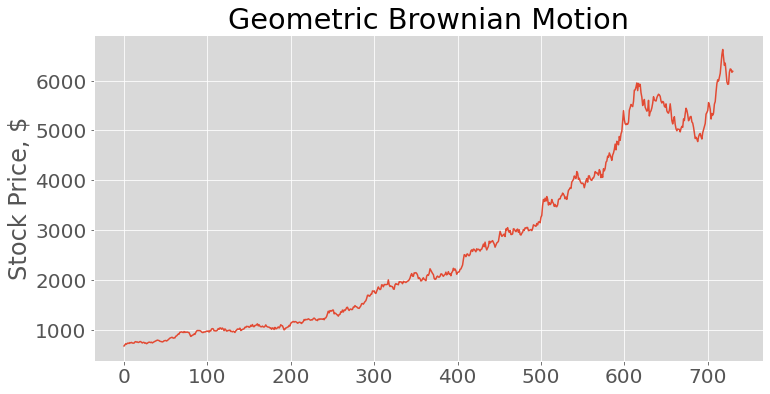

In [6]:
So = 670 # Initial price
mu = 2.5 # Underlying rate of price increase 
sigma = 0.5 # Volatility coefficient
N = 730 ## of Days in time series. Simulate 2 years but only use 1 year in evaluation. 
## 2nd year is used for observing what happens to sold CC's with expirations up to a year out

seed = 8
W = Brownian(seed, N)[0]
T = 1.
soln, t = GBM(So, mu, sigma, W, T, N)    # Generate price series


plt.plot(soln)
plt.ylabel('Stock Price, $')
plt.title('Geometric Brownian Motion')

In [7]:
percentOTM = 5 # Percentage of how far out from current price do you set strike price (5%)
percentFromStrike = 0 # How close to strike price does stock price need to get to trigger the rolling process
                      #(0 = strike price, positive are OTM, negative ITM)
    
percentStrikeScale = 5 # How much to increase strike price when rolling. Ea
premiumSell, premiumClose, timeSell, timeClose, strikeP, closeP, gain, closeOut = covered_call(soln, percentOTM, percentFromStrike, 0.5, percentStrikeScale)

premiumSell = np.round(np.array(premiumSell), 2)
premiumClose = np.round(np.array(premiumClose), 2)
gain = np.round(np.array(gain), 2)
strikeP = np.round(np.array(strikeP), 2)
closeP = np.round(np.array(closeP), 2)

In [8]:
print(gain) # How much did underlying stock price appreciate (e.g. 1.00 = no gain, 2.00 = 100% gain, etc...)
print((premiumSell-premiumClose).sum()) # Premium earning
print(closeOut) # Did shares get assigned (i.e. could not rollout further)


3.04
28.610000000000014
1


# Simulation run

In [9]:
N = 1400
seed = 8

T = 1.


So = 700
mu = 0.5
sigma = 1.0



n1 = 9;n2 = 9; n3 = 9 ## Resolution of sampling each parameter

### Create grid of various rolling parameters
OTM = np.linspace(3,10, n1)
strike = np.linspace(-5, 2, n2)
scale = np.linspace(1, 10,n3)
nSim = 10000

OTMall = []
strikeAll = []
scaleAll = []

avg = []
maxGain = []
sd = []
mn = []

avg2 = []



allPremium = []
stdPremium = []
timeCloseAll = []
timeSellAll = []
pSellAll = []
pCloseAll = []
#             strikeAll = []
closeAll = []
gainAll = []
closeOutAll = []

pAll = []

for n in range(0,nSim):

    
    percentOTM = np.random.rand(1)[0] * (OTM[-1] - OTM[0]) + OTM[0]
    
    percentFromStrike = np.random.rand(1)[0] * (strike[-1] - strike[0]) + strike[0]
    percentStrikeScale = np.random.rand(1)[0] * (scale[-1] - scale[0]) + scale[0]
    goal = 2.00 # Target 
    gn = 0
    sigma = 0.5
#                 mu = 1.0 + 6*np.random.rand(1)
#                 price_series, t = GBM(So, mu, sigma, W, T, N)
#                 gn = price_series[364] / price_series[0]

    mu = 3.0

    count = 0
    while (gn < (goal - 0.25)) | (gn > (goal + 0.25)):
        if gn < (goal - 0.25):
            count -= 1
        else:
            count += 1
        W = Brownian(seed, N)[0]
        price_series, t = GBM(So, mu, sigma, W, T, N)
        gn = price_series[364] / price_series[0]

    #print(count)
    maxGain.append(gn)

    pAll.append(price_series)
    premiumSell, premiumClose, timeSell, timeClose, strikeP, closeP, gain, closeOut = covered_call(price_series, percentOTM, percentFromStrike, sigma, percentStrikeScale)

    gainAll.append(gain)
    closeOutAll.append(closeOut)
    netPremium = premiumSell - premiumClose
    allPremium.append(netPremium.sum())
    stdPremium.append(netPremium.std())
    timeCloseAll.append(timeClose)
    timeSellAll.append(timeSell)
    pSellAll.append(premiumSell)
    pCloseAll.append(premiumClose)
    #strikeAll.append(strikeP)
    closeAll.append(closeP)


    OTMall.append(percentOTM)
    strikeAll.append(percentFromStrike)
    scaleAll.append(percentStrikeScale)

    avg.append(gain)

    mn.append(closeOut)        

    avg2.append(netPremium.sum())


In [10]:
gainAll = np.array(avg)
maxGainAll = np.array(maxGain)
closedAll = np.array(mn)
premAll = np.array(avg2)

df = pd.DataFrame()
df['OTM'] = OTMall
df['strike'] = strikeAll
df['scale'] = scaleAll
df['totGain'] = 100*(gainAll-1) + 100*premAll/So
df['premGain'] = 100 * premAll/So
df['stockGain'] = 100*(gainAll-1)
df['closed'] = closedAll
df['maxGain'] = 100*(maxGainAll-1)


<AxesSubplot:xlabel='premGain', ylabel='Density'>

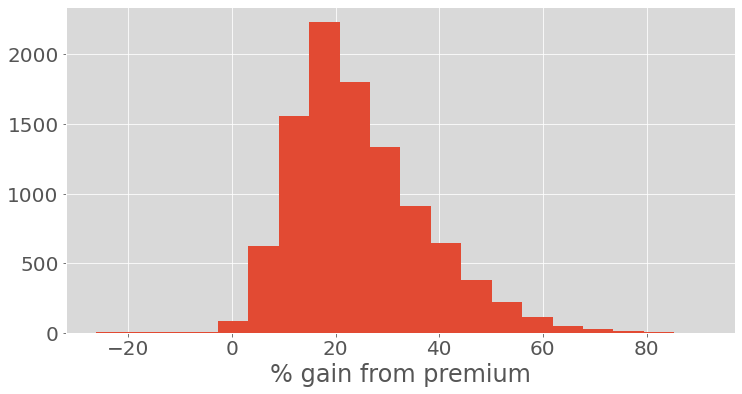

<Figure size 864x432 with 0 Axes>

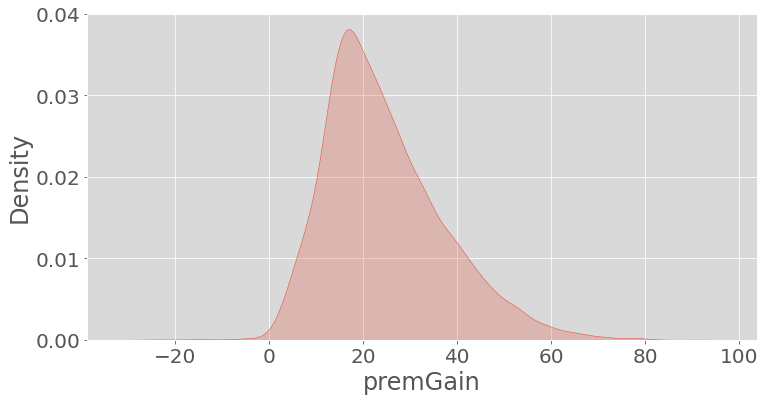

In [11]:


plt.hist(100 *premAll/So, bins = 20)
plt.xlabel('% gain from premium')
plt.figure()
plt.figure()
sns.kdeplot(data = df, x = 'premGain', fill = True)


<AxesSubplot:xlabel='maxGain', ylabel='Density'>

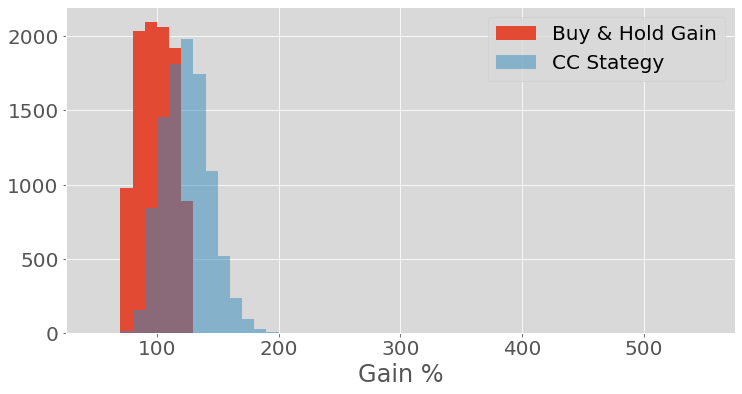

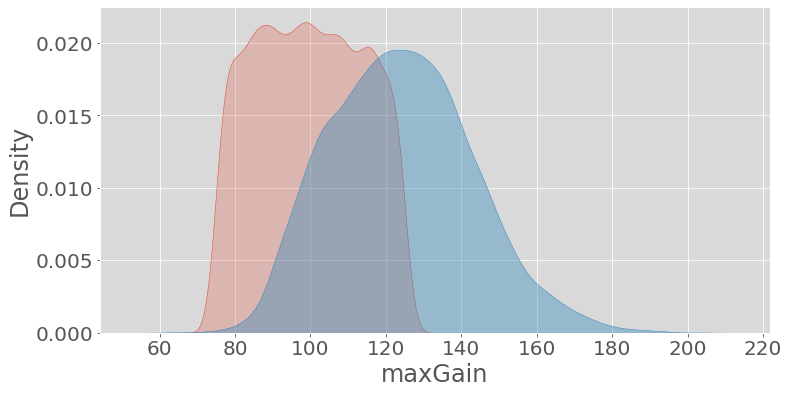

In [12]:
ind = np.where(premAll >0)[0]
plt.hist(100 * (maxGainAll[ind]-1), bins = 50, range = [50, 550])
plt.hist(100*(gainAll[ind]-1) + 100*premAll[ind]/So, alpha = 0.5, bins =50, range = [50, 550])

plt.xlabel('Gain %')
plt.legend(('Buy & Hold Gain','CC Stategy'))

plt.figure()
sns.kdeplot(data = df, x = 'maxGain', fill = True)
sns.kdeplot(data = df, x = 'totGain', fill = True, alpha = 0.4)


<AxesSubplot:xlabel='stockGain', ylabel='premGain'>

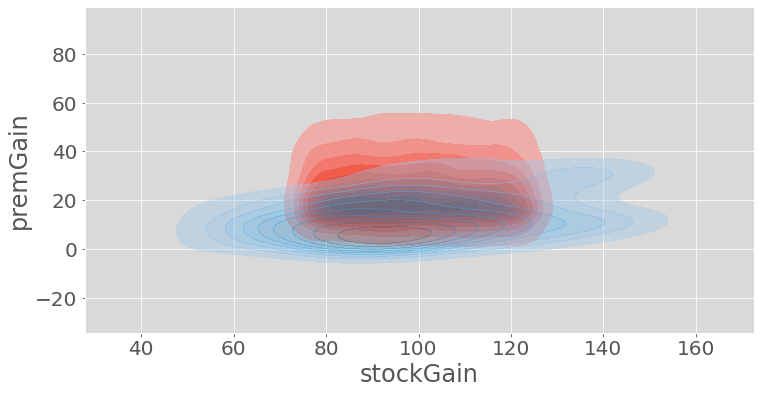

In [13]:
# ind = np.where(closedAll == 1)[0]
# ind1 = np.where(closedAll == 0)[0]
# plt.plot(100*(gainAll[ind1]-1), 100*premAll[ind1]/So, '.')
# plt.plot(100*(gainAll[ind]-1), 100*premAll[ind]/So, 'k.')
# plt.xlabel('Stock Appreciation %')
# plt.ylabel('Net Premium Gain %')

dfClosed = df[df['closed'] == 1]
dfOpen = df[df['closed'] == 0]
plt.figure()
sns.kdeplot(data = dfOpen, x = 'stockGain', y = 'premGain', fill = True)
sns.kdeplot(data = dfClosed, x = 'stockGain', y = 'premGain', fill = True, alpha = 0.4)


<AxesSubplot:xlabel='OTM', ylabel='premGain'>

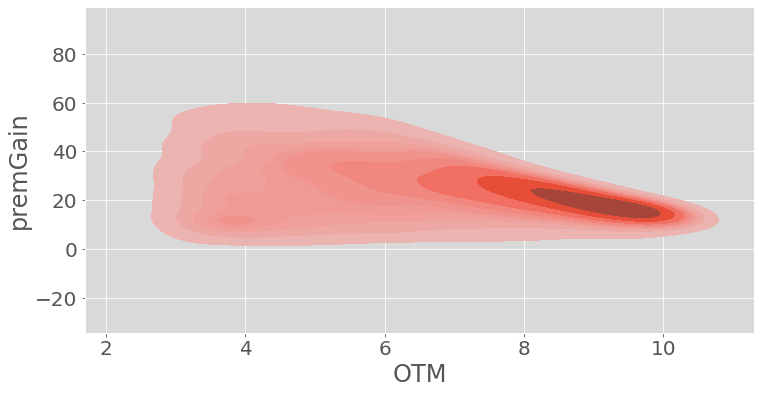

In [14]:


sns.kdeplot(data = df, x = 'OTM', y = 'premGain', fill = True)


<AxesSubplot:xlabel='strike', ylabel='premGain'>

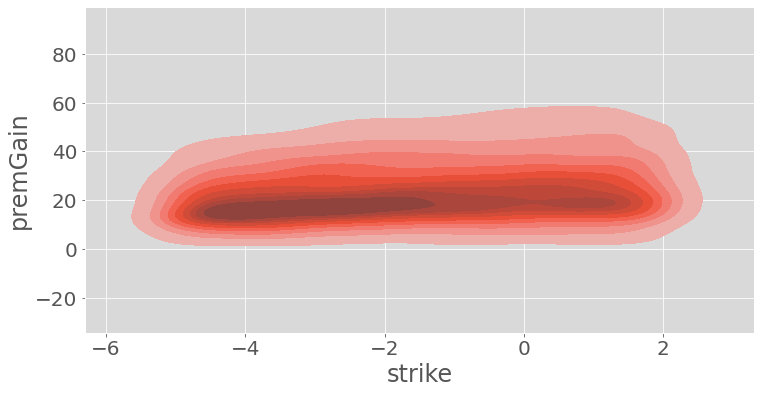

In [15]:
sns.kdeplot(data = df, x = 'strike', y = 'premGain', fill = True)

<AxesSubplot:xlabel='scale', ylabel='premGain'>

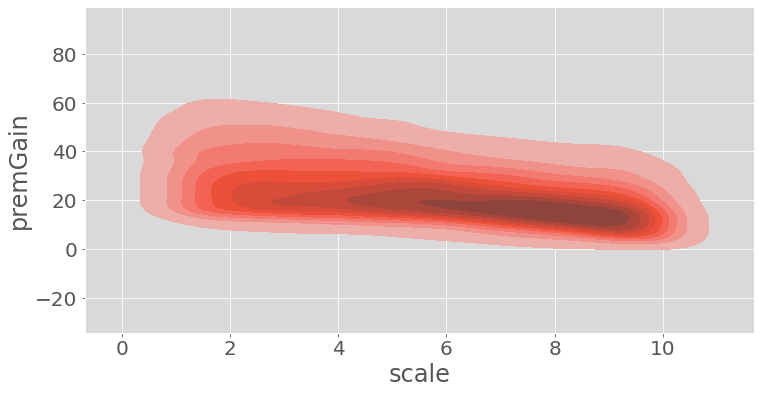

In [16]:
sns.kdeplot(data = df, x = 'scale', y = 'premGain', fill = True)

In [17]:
np.array(OTMall)

array([8.24759287, 6.39958958, 8.18359415, ..., 5.72815287, 6.38038324,
       7.47218142])

In [18]:
np.random.rand(1) * (OTM[-1] - OTM[0]) + OTM[0]


array([7.77538104])

In [19]:
OTM[-1]

10.0

In [20]:
np.random.rand(1)[0]

0.7118537151978707

In [21]:
closedAll.mean()

0.0072